In [1]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob


import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

In [2]:
# Load configuration
with open("../config/config_notebooks.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [3]:
import math
def make_spider(df, row, color, title, min=0, max=1):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5))
 
    ax = plt.subplot(1,1,1, polar=True)
 
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
 
   
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.tick_params(axis='x', rotation=5.5)
    
    ax.set_rlabel_position(0)
    
    tick_values = np.linspace(min, max, 5)
    tick_strings = [f"{value:.2e}" for value in tick_values]
    plt.yticks(tick_values, tick_strings, color="black", size=10)
    plt.ylim(min, max)
 
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.1)
 
  
    plt.title(title, fontsize=20, x = 0.5, y = 1.1)

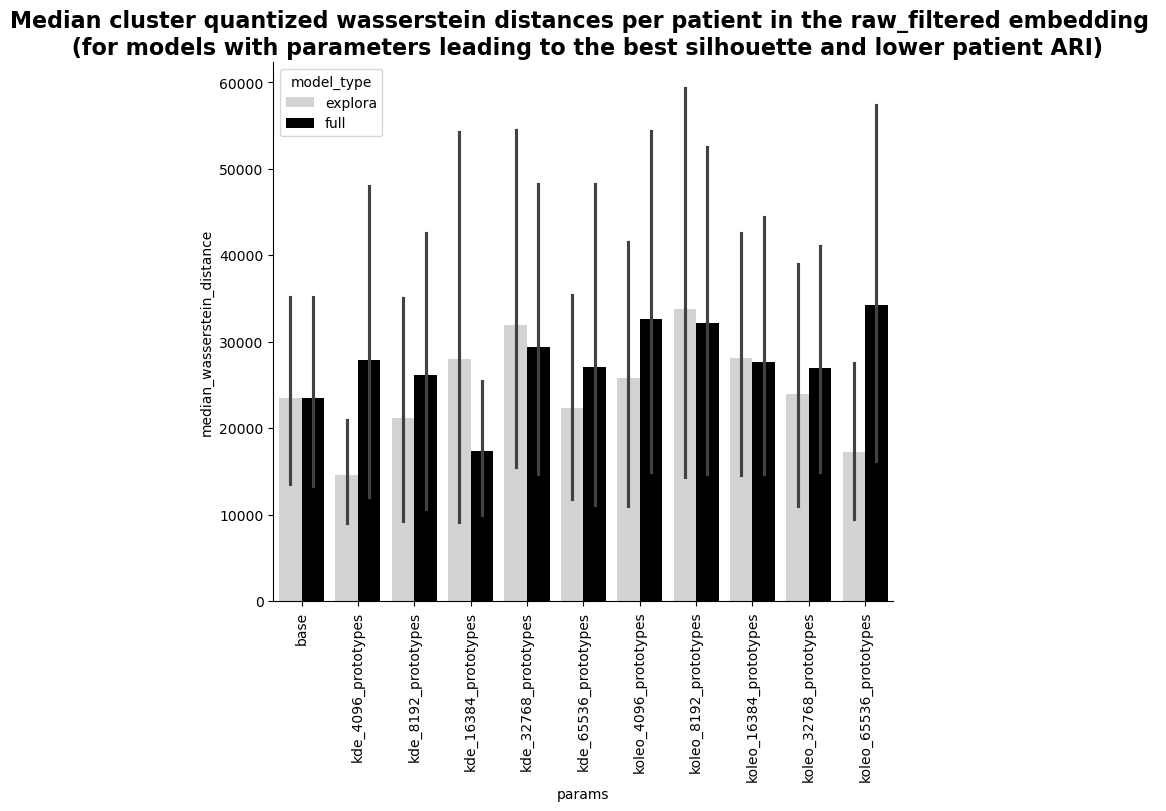

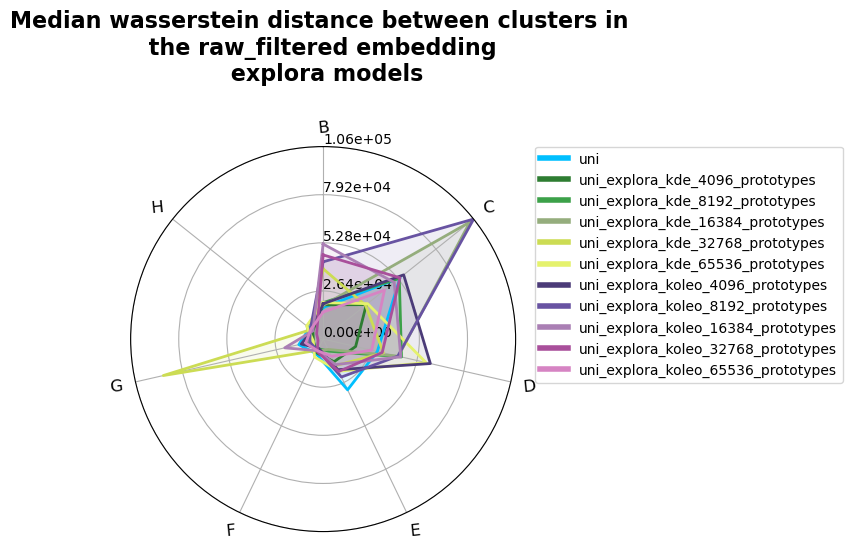

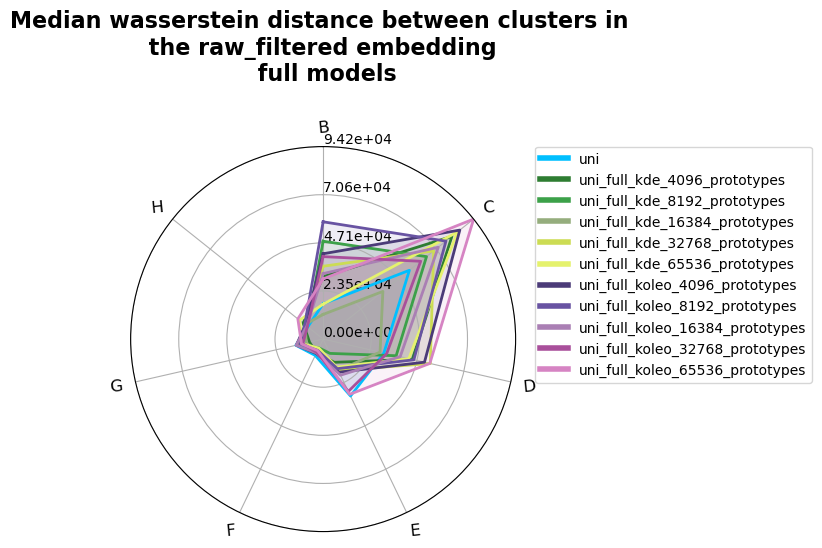

In [10]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(["B", "C", "D", "E", "F", "G", "H"]):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []

    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        


        for name in names:

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_raw_filtered_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)


            mean_wasserstein_distance = np.mean(wasserstein_distances)
            std_wasserstein_distance = np.std(wasserstein_distances)
            median_wasserstein_distance = np.median(wasserstein_distances)

            min_wasserstein_distance = np.min(wasserstein_distances)
            max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")

df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
plt.figure(figsize=(8, 7))
sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
plt.xticks(rotation=90)
sns.despine()

plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw_filtered embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
#plt.yscale("log")
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_raw_filtered_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()

for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    plt.figure()
    for j, name in enumerate(names):
        if name == "uni":
            name = f"uni_{model_type}"
        d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
        make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
       # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

        # print(name)

        handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
        plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    plt.title(f"Median wasserstein distance between clusters in \n the raw_filtered embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw_filtered_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')

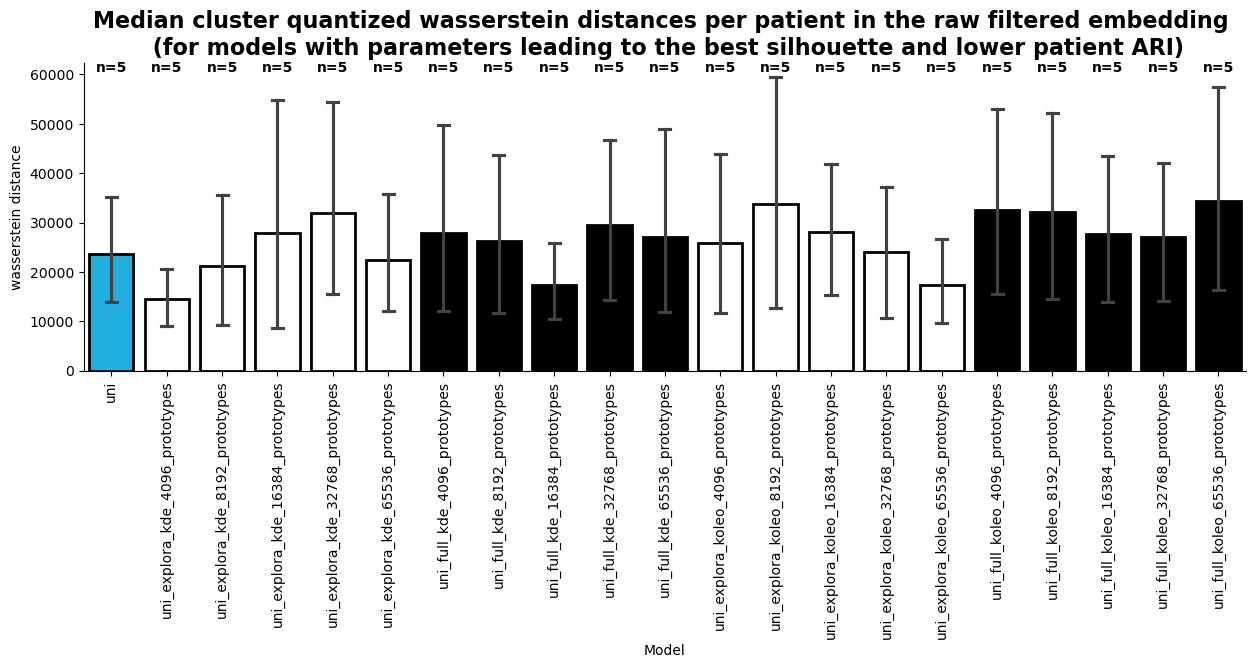

In [12]:
dfs = []
n_clusters = []
for model_type in ["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_8192_prototypes",
              "uni_explora_kde_16384_prototypes",
              "uni_explora_kde_32768_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_8192_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_32768_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_8192_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_32768_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_8192_prototypes",
                "uni_full_koleo_16384_prototypes",
               "uni_full_koleo_32768_prototypes",
                "uni_full_koleo_65536_prototypes"]:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=["deepskyblue", "white", "white", "white", "white", "white", "black", 
         "black", "black","black", "black", "white", "white", "white", 
         "white", "white", "black", "black", "black", "black","black", ], 
# palette=["deepskyblue", "white", "white", "white","black", 
#           "black", "black", "white", "white", "white", 
#         "black", "black", "black", ],
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw filtered embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=60000, s=f"n={n}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw filtered_embedding_per_patient.pdf"), bbox_inches='tight')

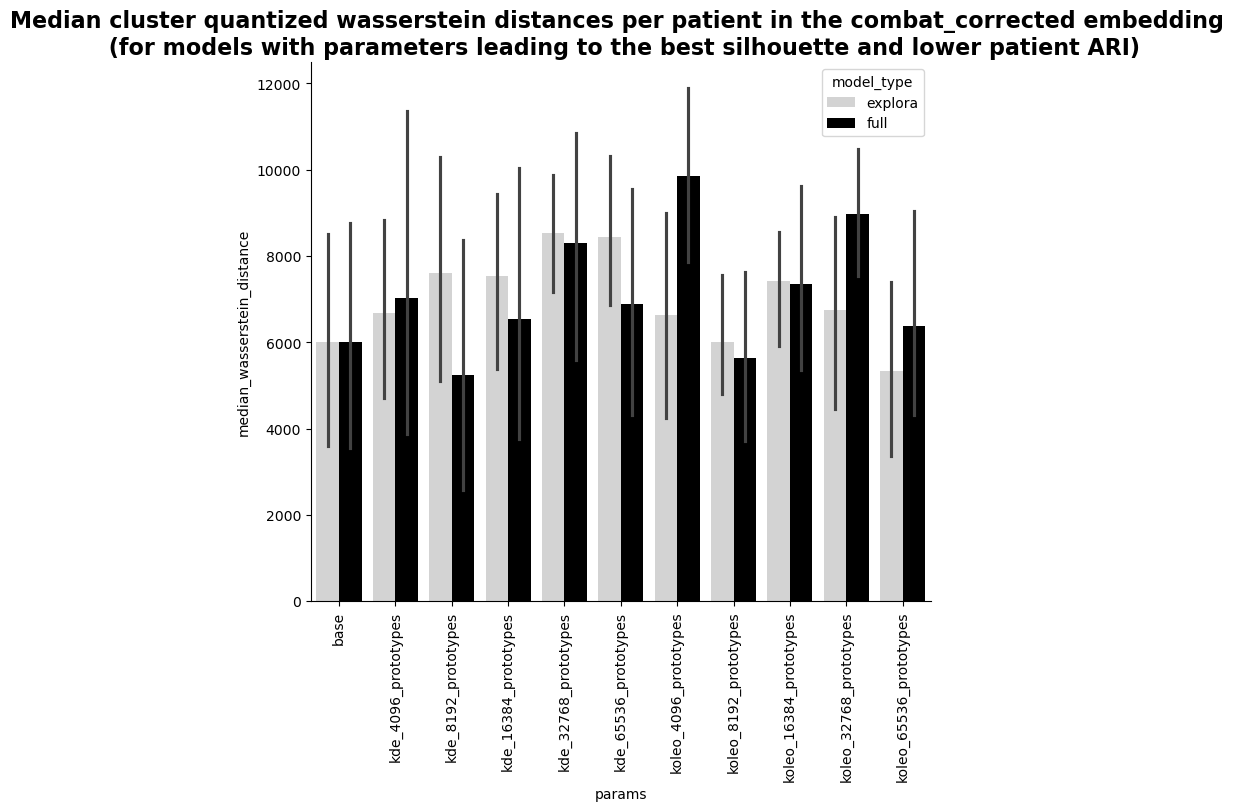

In [5]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(["B", "C", "D", "E", "F", "G", "H"]):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []


    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        
        


        for name in names:

            # print(f"model_type: {name}, optimal clusters: {opti_clusters.loc[name, 'n_clusters']}")

            
        # print(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv"))
            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)


            mean_wasserstein_distance = np.mean(wasserstein_distances)
            std_wasserstein_distance = np.std(wasserstein_distances)
            median_wasserstein_distance = np.median(wasserstein_distances)

            min_wasserstein_distance = np.min(wasserstein_distances)
            max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
plt.figure(figsize=(8, 7))
sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
plt.xticks(rotation=90)
sns.despine()

plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
#plt.yscale("log")
plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()




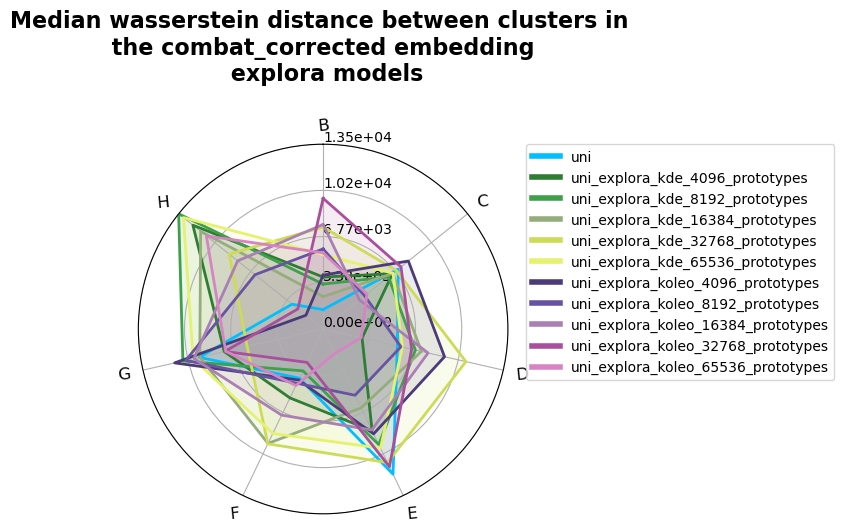

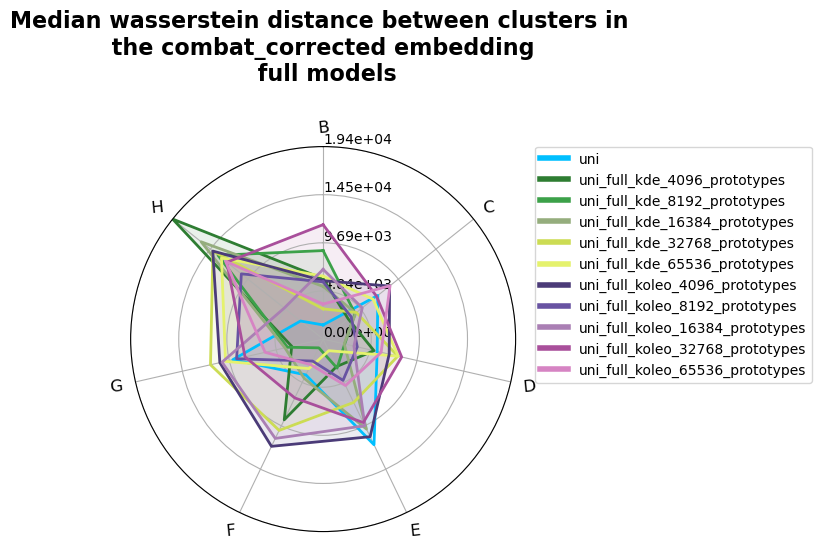

In [6]:
for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    plt.figure()
    for j, name in enumerate(names):
        if name == "uni":
            name = f"uni_{model_type}"
        d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
        make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
       # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

        # print(name)

        handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
        plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    plt.title(f"Median wasserstein distance between clusters in \n the combat_corrected embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
    plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')



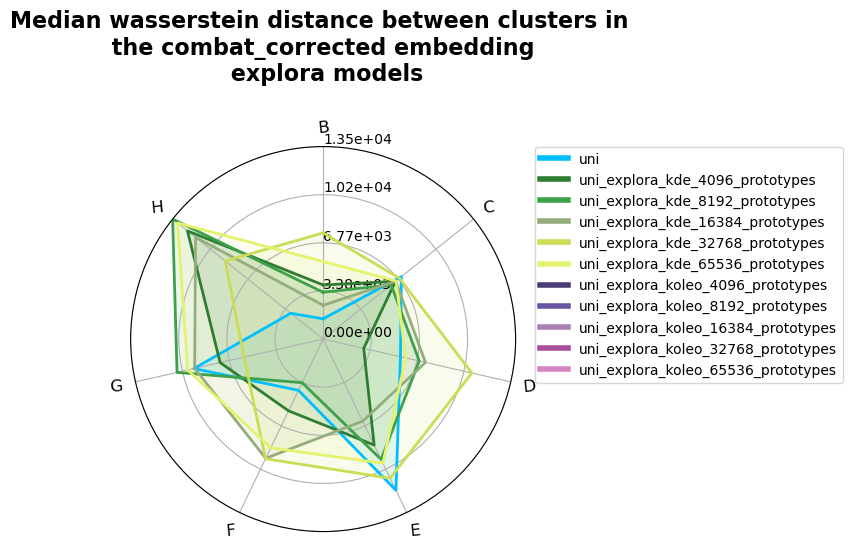

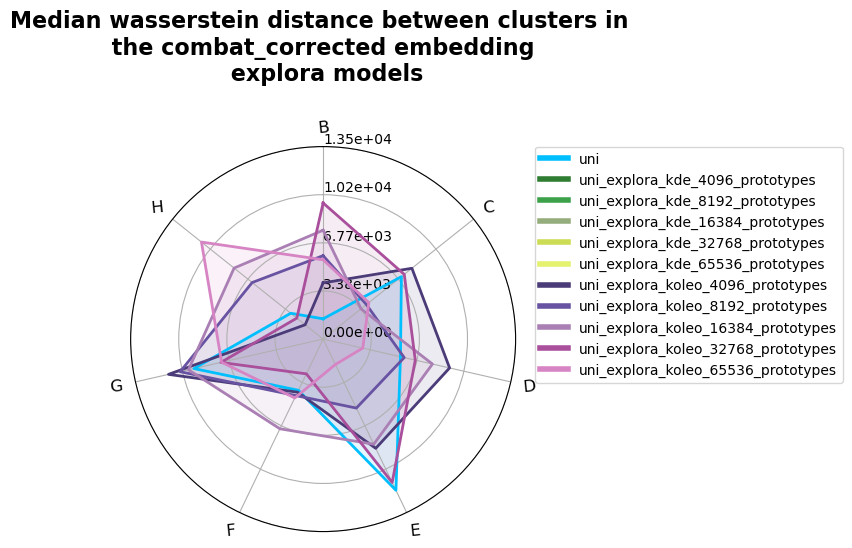

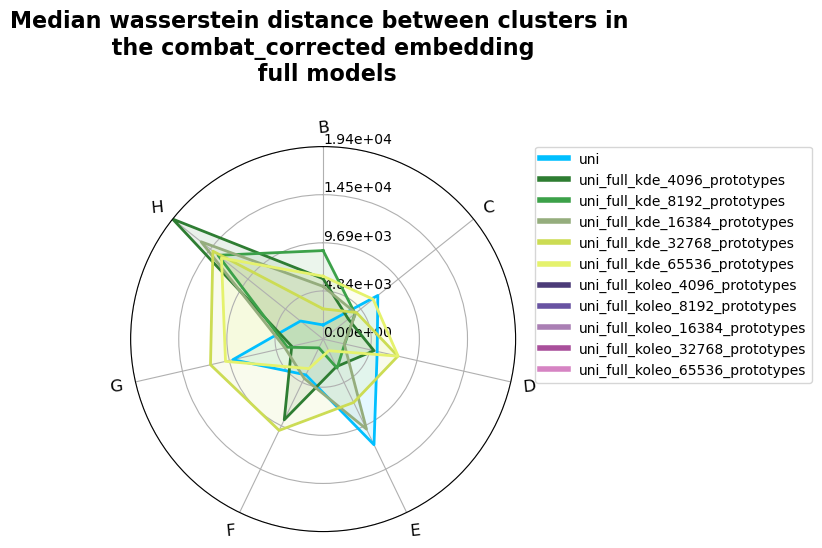

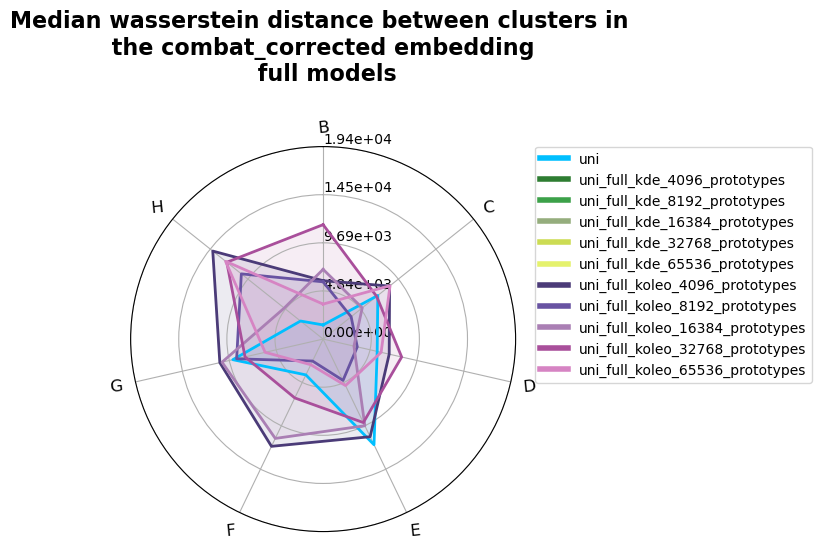

In [7]:
for model_type, names in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']]):
    for loss in ["kde", "koleo"]:
        plt.figure()
        for j, name in enumerate(names):
            if name == "uni":
                name = f"uni_{model_type}"
            if (loss in name) or (name == f"uni_{model_type}"):
                d_s = df_spider[(df_spider['model'] == name) & (df_spider['model_type'] == model_type)].set_index("patient").T
                make_spider(d_s, row=5, color=a[j], title=name, min=0, max=df_spider[(df_spider['model_type'] == model_type)]['median_wasserstein_distance'].max())
            # make_spider(d_s, row=3, color=models_palette[j], title=name, min=0, max=40000)

                # print(name)

                handles = [plt.Line2D([0], [0], color=a[i], lw=4) for i in range(len(names))]
                plt.legend(handles, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        plt.title(f"Median wasserstein distance between clusters in \n the combat_corrected embedding \n {model_type} models", y=1.15, weight='bold', fontsize=16)
        plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_embedding_per_patient_{model_type}.pdf"), bbox_inches='tight')


In [36]:
d_s

patient,B,C,D,E,F,G,H
model,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes,uni_full_koleo_65536_prototypes
n_clusters,5,3,5,5,5,5,5
wasserstein_distances,"[193.71528973714132, 886.0607542310577, 982.60...","[979.225324377558, 8613.469151498884, 8650.348...","[891.3373094244627, 1917.5202359737336, 2214.2...","[456.5722334031772, 1456.7332853350204, 1471.9...","[1637.2896412517125, 1474.5025960838664, 1091....","[1068.4129534058827, 4223.520377156685, 5132.6...","[10623.441577732445, 10407.27731093795, 4574.6..."
mean_wasserstein_distance,4380.485072,6081.01427,6194.584349,7101.81014,5654.989065,7941.25536,13269.487552
std_wasserstein_distance,3137.793306,3607.540977,3625.617868,5292.460779,4452.5675,4751.608464,5204.793337
median_wasserstein_distance,3520.414159,8613.469151,5986.256181,5192.223276,2861.767874,5988.285126,12560.988778
min_wasserstein_distance,193.71529,979.225324,891.337309,456.572233,1091.434295,1068.412953,4574.611712
max_wasserstein_distance,9951.221319,8650.348335,12401.590424,15843.494288,11882.103444,15128.099452,21903.853266
model_type,full,full,full,full,full,full,full
params,koleo_65536_prototypes,koleo_65536_prototypes,koleo_65536_prototypes,koleo_65536_prototypes,koleo_65536_prototypes,koleo_65536_prototypes,koleo_65536_prototypes


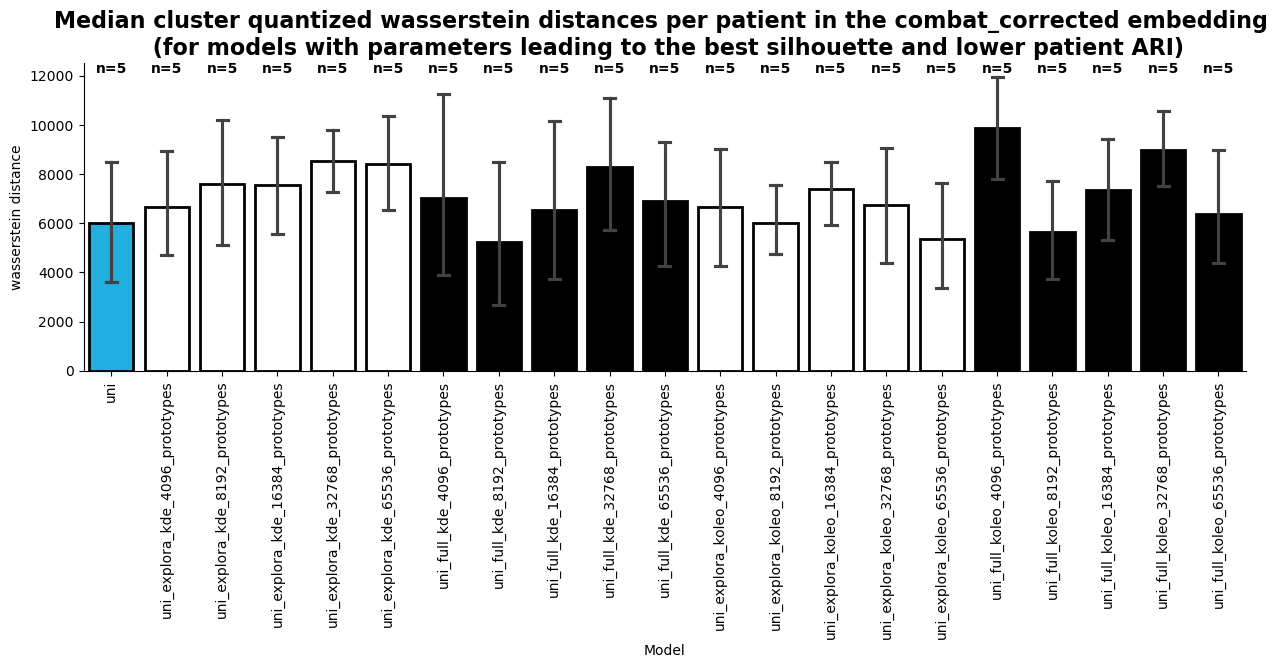

In [9]:
dfs = []
n_clusters = []
for model_type in ["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_8192_prototypes",
              "uni_explora_kde_16384_prototypes",
              "uni_explora_kde_32768_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_8192_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_32768_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_8192_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_32768_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_8192_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_32768_prototypes",
                "uni_full_koleo_65536_prototypes"]:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=["deepskyblue", "white", "white", "white", "white", "white", "black", 
         "black", "black","black", "black", "white", "white", "white", 
         "white", "white", "black", "black", "black", "black","black", ], 
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=12000, s=f"n={n}", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_embedding_per_patient.pdf"), bbox_inches='tight')

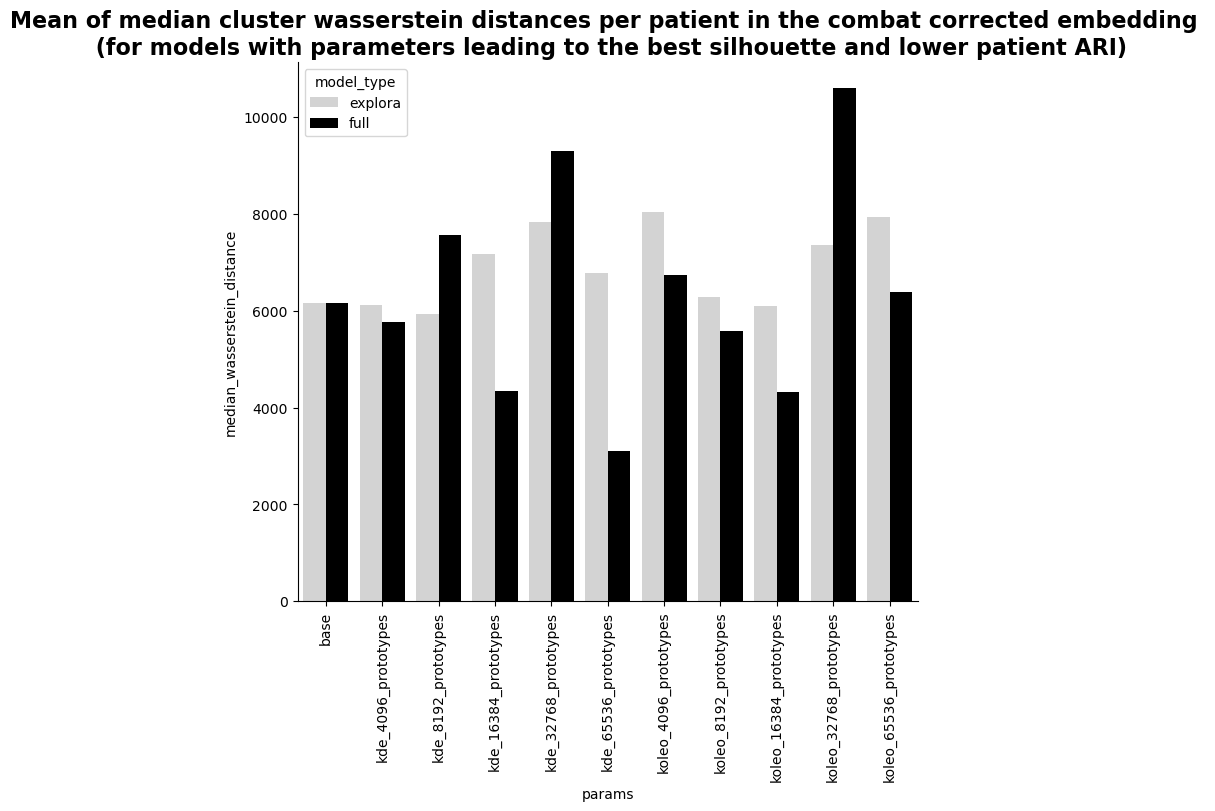

In [ ]:
## Mean wasserstein distance per patient
stat = 'median'
plt.figure(figsize=(8, 7))
sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"}, ci=None)
plt.xticks(rotation=90)
sns.despine()

plt.title(f"Mean of {stat} cluster wasserstein distances per patient in the combat corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
plt.savefig(f"../Figures/Fig3/mean_{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding_log_scale.pdf", bbox_inches='tight')